<a href="https://colab.research.google.com/github/joaquinparodi/TP1-DATOS/blob/main/tp2orga_joaquin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
!pip install ptitprince
import ptitprince as pt
import pandas as pd
import numpy as np


     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for ptitprince: filename=ptitprince-0.2.5-cp36-none-any.whl size=8428 sha256=3ea7476f1ece944b0b1e70b709567e60e46b4cd0d9061cb71f95b290c0693953
  Stored in directory: /root/.cache/pip/wheels/fb/c1/75/2ef8da161053bdf8e03f9a360f426accd4fac1ddf7f6ed0029
Successfully built ptitprince


In [2]:
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
 
id='1MfnxlPGSmr-i1up_2iKCkrBIMcDHomnK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.csv')

In [6]:
id='1kZt5ZN2eAyeNEIWLh6lGckgyDIxpHN4f'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [9]:
test=pd.read_csv('test.csv')

In [192]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

In [11]:
class Modelo():
  def __init__(self ):
    pass



  def splitTrainTarget(self,entrenamientoFeatureTarget):
    #separo  mi dataframe en X= feature engineri e y= target
    X,y=entrenamientoFeatureTarget.iloc[:,1:-1], entrenamientoFeatureTarget.iloc[:,-1]
    print("las columnas del train son {} y del target son  {}".format(X.columns , y.name ))
    return X,y

  def SplitTrainTest(self,X,y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

    return X_train, X_test, y_train, y_test


  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(X_test)
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
     preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
     rmse = np.sqrt(mean_squared_error(y_test, preds))
     print("RMSE: %f" % (rmse)) 



  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
    listaColumnas=dfTestFeature.columns.to_list()
    listaColumnas.remove('Opportunity_ID')
    dfFeaturestest=dfFeaturestest[listaColumnas] 
    #se elemina esa columan porque sino hay overfittin
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  

  

  def agregarTargetDfOriginal(self,entrenamiento,df):
    #df es un dataframe ya agregado con features nuevos
    #entrenamiento es el dataframe orginal sin procesar
    target=entrenamiento[(entrenamiento['Stage']=='Closed Lost') | (entrenamiento['Stage']=='Closed Won')]
    target=target[['Opportunity_ID','Stage']].groupby(['Opportunity_ID','Stage']).agg(total=('Stage','count')).reset_index()[['Opportunity_ID','Stage']]
      
    entrenamiento=pd.merge(df,target,on="Opportunity_ID",how="inner") 
    df=entrenamiento.replace("Closed Lost", "0")
    df=df.replace("Closed Won", "1")
  
    return df

  #feature engnerie
  def featureEngeenier(self,df):
    #agregamos fecha 
    df['Month']=pd.to_datetime(df['Month'])
    df['anio']=df['Month'].dt.year
    df['mes']=df['Month'].dt.month
    #agregamos columna totalamount
    totalAmount=df.groupby(['Opportunity_ID' ]).agg(totalamount=('Total_Amount','sum'))
    #agregamos total trf
    totalTrf=df.groupby(['Opportunity_ID' ]).agg(totalTrf=('TRF','sum'))
    dfFeatureNew=pd.merge(totalAmount,totalTrf,on="Opportunity_ID",how="inner").reset_index()

    df=dfFeatureNew[['Opportunity_ID','totalamount','totalTrf']]
    
    return df


  def formarDfKaggle(self,testWithFeature,preds ):
    dfkaggle = pd.DataFrame( preds)
    dfkaggle['Opportunity_ID']=testWithFeature['Opportunity_ID']
    dfkaggle.columns=['Target','Opportunity_ID']
    dfkaggle=dfkaggle[['Opportunity_ID','Target']]
    
    from google.colab import files
    dfkaggle.to_csv('dfKaggle.csv', index=False) 
    files.download('dfKaggle.csv')
   
  def featureImportancia(self,X_train):
    # Gini importance
    self.modelo.feature_importances_
    plt.bar(X_train.columns, self.modelo.feature_importances_)
    plt.xlabel('Features')
    plt.ylabel('Importancia')
    plt.title('Importancia Features con RF')
    plt.show()


In [279]:
class RandomForestRegre(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= RandomForestRegressor(random_state=1,n_estimators=20)


class xgbosst(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 1000)
  


  # este polimorfismo es porque pedia el xgboost que y_train sea de tipo int
  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(X_test)
     
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
    #aca la diferencia es que ytrain debe ser entero
     
    preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))

  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
    listaColumnas=dfTestFeature.columns.to_list()
    listaColumnas.remove('Opportunity_ID')
    dfFeaturestest=dfFeaturestest[listaColumnas] 
    #se elemina esa columan porque sino hay overfittin
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  


In [280]:
#1)Apertura
entrenamiento = pd.read_csv('data.csv')
df=entrenamiento 

In [281]:
random_state=1
n_estimators=20
#aca agregamos los hiperparametros que estamos probando
Hiperparametros=[random_state ,n_estimators ]
#por ahora no se usan los hirparametros, se setea dentro de las clase estos,
#pero la idea es que se pueda setear desde afuera para probar

In [282]:
modelos={
         'ramdomForest': RandomForestRegre(Hiperparametros),
         'xgboost':xgbosst(Hiperparametros)
}

In [283]:


modelo=modelos.get('xgboost')
#cargamos el modelo 
modelo=modelo
#hacemos feature engierine sobre el df original
dfFeature=modelo.featureEngeenier(entrenamiento)
dfFeature.head()
#le agregamos el target
dfFeatureWithTarget=modelo.agregarTargetDfOriginal(entrenamiento,dfFeature)
dfFeatureWithTarget.head()

,Opportunity_ID,totalamount,totalTrf,Stage
0,0,5272800.0,10,0
1,1,48230.0,0,1
2,2,83865.6,0,1
3,3,7421881.5,14,0
4,4,13357192.5,25,0


In [284]:
df=entrenamiento 
df = df.replace('Closed Won', '1')
df = df.replace('Closed Lost', '0')
df = df[df['Stage'].isin(['0','1'])]
df.Stage = df.Stage.astype(int)
df = df.groupby(['Territory','Opportunity_ID']).agg({'Stage':['sum','count']})
df = df.reset_index()
df1 = df
df1.columns = ['Territory','Opportunity_ID','Stage_sum','Stage_count']
df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
df2 = df1.groupby(['Territory']).agg(meanEncodingTerritory = ('Stage_sum','mean'))
df2 = df2.reset_index()
agruparOportunity=entrenamiento.groupby(['Opportunity_ID','Territory']).agg(cant=('Territory','count')).reset_index()
result=pd.merge(agruparOportunity,df2,on='Territory',how='inner')
result.head()
del result['cant']
 
result2=pd.merge(dfFeatureWithTarget, result, on='Opportunity_ID' , how='inner')
del result2['Territory']
 
dfFeatureWithTarget=result2
dfFeatureWithTarget.Stage = dfFeatureWithTarget.Stage.astype(int)

In [285]:

dfFeatureWithTarget=dfFeatureWithTarget[['Opportunity_ID', 	'totalamount', 	'totalTrf', 	 	'meanEncodingTerritory','Stage']]

In [286]:
dfFeatureWithTarget

,Opportunity_ID,totalamount,totalTrf,meanEncodingTerritory,Stage
0,0,5272800.00,10,0.535927,0
1,1,48230.00,0,0.535927,1
2,2,83865.60,0,0.632723,1
3,3,7421881.50,14,0.632723,0
4,4,13357192.50,25,0.632723,0
...,...,...,...,...,...
9786,12799,401700.00,1,0.388889,1
9787,12800,21332500.00,40,0.347490,0
9788,12801,299715.00,0,0.805556,1
9789,12802,2346796.88,4,0.347490,0


aca vamos a entrenar y testear con el mismo dataframe original, asi vemos
que error nos da

In [287]:
X,y=modelo.splitTrainTarget(dfFeatureWithTarget)

las columnas del train son Index(['totalamount', 'totalTrf', 'meanEncodingTerritory'], dtype='object') y del target son  Stage


In [288]:
#separamos para entrenar (X_train, y_train) y para predecir (y_train) y su prediccion real(y_test)
X_train, X_test, y_train, y_test=modelo.SplitTrainTest(X,y)

In [289]:
dfFeatureWithTarget.dtypes

Opportunity_ID             int64
totalamount              float64
totalTrf                   int64
meanEncodingTerritory    float64
Stage                      int64
dtype: object

In [290]:
#entrenamo y predecimos, y comparamos con el valor real y vemos su error
modelo.errorSetEntrenamiento(  X_train,y_train,X_test,y_test) 
     

RMSE: 0.421715


aca vamos a entrenar y predecir con el test para subir a kaggle

In [293]:
df=entrenamiento 
df = df.replace('Closed Won', '1')
df = df.replace('Closed Lost', '0')
df = df[df['Stage'].isin(['0','1'])]
df.Stage = df.Stage.astype(int)
df = df.groupby(['Territory','Opportunity_ID']).agg({'Stage':['sum','count']})
df = df.reset_index()
df1 = df
df1.columns = ['Territory','Opportunity_ID','Stage_sum','Stage_count']
df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
df2 = df1.groupby(['Territory']).agg(meanEncodingTerritory = ('Stage_sum','mean'))
df2 = df2.reset_index()
agruparOportunity=entrenamiento.groupby(['Opportunity_ID','Territory']).agg(cant=('Territory','count')).reset_index()
result=pd.merge(agruparOportunity,df2,on='Territory',how='inner')
result.head()
del result['cant']
result

,Opportunity_ID,Territory,meanEncodingTerritory
0,0,None,0.535927
1,1,None,0.535927
2,8,None,0.535927
3,9,None,0.535927
4,10,None,0.535927
...,...,...,...
9834,10218,Oman,0.000000
9835,10419,Oman,0.000000
9836,7447,Burma,0.000000
9837,8677,Slovenia,1.000000


In [294]:
result2=result[['Territory','meanEncodingTerritory']].drop_duplicates()
result2.value_counts()

Territory    meanEncodingTerritory
Vietnam      0.365854                 1
Denmark      0.500000                 1
Estonia      0.800000                 1
France       0.295165                 1
Georgia      0.000000                 1
                                     ..
Philippines  0.320988                 1
Poland       0.279070                 1
Portugal     0.469388                 1
Romania      0.000000                 1
Albania      0.000000                 1
Length: 75, dtype: int64

In [295]:
test=pd.read_csv('test.csv')
test=pd.merge(test,result2,on='Territory', how='inner')

In [296]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2545 entries, 0 to 2544
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  2545 non-null   int64  
 1   Region                              2545 non-null   object 
 2   Territory                           2545 non-null   object 
 3   Pricing, Delivery_Terms_Quote_Appr  2545 non-null   int64  
 4   Pricing, Delivery_Terms_Approved    2545 non-null   int64  
 5   Bureaucratic_Code_0_Approval        2545 non-null   int64  
 6   Bureaucratic_Code_0_Approved        2545 non-null   int64  
 7   Submitted_for_Approval              2545 non-null   int64  
 8   Bureaucratic_Code                   2545 non-null   object 
 9   Account_Created_Date                2545 non-null   object 
 10  Source                              2545 non-null   object 
 11  Billing_Country                     2545 no

In [297]:
 len(test['Territory'].value_counts())

44

In [298]:
 len(result2['Territory'].value_counts())

75

In [302]:
algo=test.groupby(['Opportunity_ID','Territory' ]).agg(cant=('Opportunity_ID','count')).reset_index()
algo

,Opportunity_ID,Territory,cant
0,10689,Germany,3
1,10690,Germany,5
2,10691,NE America,1
3,10692,NW America,6
4,10693,NW America,1
...,...,...,...
1562,12364,KSA,2
1563,12365,SE America,1
1564,12366,SE America,1
1565,12367,NE America,1


In [300]:
test=pd.read_csv('test.csv')
df=test

In [304]:
territories=pd.merge(algo,result2, on="Territory", how='left') 
territories=territories.groupby('Opportunity_ID').agg(meanEncodingTerritory=('meanEncodingTerritory','mean')).reset_index()


In [305]:
 
df['Month']=pd.to_datetime(df['Month'])
df['anio']=df['Month'].dt.year
df['mes']=df['Month'].dt.month
#agregamos columna totalamount
totalAmount=df.groupby(['Opportunity_ID' ]).agg(totalamount=('Total_Amount','sum'))
#agregamos total trf
totalTrf=df.groupby(['Opportunity_ID' ]).agg(totalTrf=('TRF','sum'))
dfFeatureNew=pd.merge(totalAmount,totalTrf,on="Opportunity_ID",how="inner").reset_index()
dfFeatureNew 

dfFeatureNew=pd.merge(dfFeatureNew,territories,on='Opportunity_ID',how='inner')
dfFeatureNew=dfFeatureNew.fillna(0)
dfFeatureNew=dfFeatureNew[['Opportunity_ID','totalamount','totalTrf','meanEncodingTerritory']]


In [306]:
dfFeatureNew.info()
#dfTestFeature=modelo.featureEngeenier(test)
#dfTestFeature.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1567 entries, 0 to 1566
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Opportunity_ID         1567 non-null   int64  
 1   totalamount            1567 non-null   float64
 2   totalTrf               1567 non-null   int64  
 3   meanEncodingTerritory  1567 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 61.2 KB


In [307]:
X_train

,totalamount,totalTrf,meanEncodingTerritory
6509,323212.5,0,0.813953
6914,463600.0,0,0.535927
2464,1679730.0,5,0.593750
913,498771.0,1,0.367953
4986,52126.0,0,0.379310
...,...,...,...
9785,1307775.0,3,0.548148
7763,103125.0,0,0.593750
5218,292410.0,1,0.417755
1346,326340.0,0,0.802326


In [308]:
y_train

6509    1
6914    1
2464    0
913     0
4986    1
       ..
9785    0
7763    1
5218    0
1346    1
3582    0
Name: Stage, Length: 7832, dtype: int64

In [309]:
dfFeatureNew[['totalamount' ,	'totalTrf', 	'meanEncodingTerritory']]

,totalamount,totalTrf,meanEncodingTerritory
0,367419.0,0,0.548148
1,757783.5,1,0.548148
2,21037.5,0,0.347490
3,2169106.5,6,0.632723
4,5752.5,0,0.632723
...,...,...,...
1562,147750.0,0,0.416667
1563,45054.9,0,0.367953
1564,100122.0,0,0.367953
1565,143220.0,0,0.347490


In [310]:
listaColumnas=dfFeatureNew.columns.to_list()
listaColumnas.remove('Opportunity_ID')
dfFeaturestest=dfFeatureNew[listaColumnas] 
#totalamount 	totalTrf 	meanEncodingTerritory
dfFeaturestest

,totalamount,totalTrf,meanEncodingTerritory
0,367419.0,0,0.548148
1,757783.5,1,0.548148
2,21037.5,0,0.347490
3,2169106.5,6,0.632723
4,5752.5,0,0.632723
...,...,...,...
1562,147750.0,0,0.416667
1563,45054.9,0,0.367953
1564,100122.0,0,0.367953
1565,143220.0,0,0.347490


In [311]:
listaColumnas=dfFeatureNew.columns.to_list()
listaColumnas.remove('Opportunity_ID')
dfFeaturestest=dfFeatureNew[listaColumnas] 
#se elemina esa columan porque sino hay overfittin
xgb2=xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 1000)
  
xgb2.fit(X_train, y_train.astype(int))
preds =  xgb2.predict(dfFeaturestest)

In [312]:
len(preds)

1567

In [177]:
#prediccion=modelo.entrenarYPredecirWithTest(X_train,y_train,dfFeatureNew)
#prediccion

ValueError: ignored

In [313]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  2551 non-null   int64         
 1   Region                              2551 non-null   object        
 2   Territory                           2551 non-null   object        
 3   Pricing, Delivery_Terms_Quote_Appr  2551 non-null   int64         
 4   Pricing, Delivery_Terms_Approved    2551 non-null   int64         
 5   Bureaucratic_Code_0_Approval        2551 non-null   int64         
 6   Bureaucratic_Code_0_Approved        2551 non-null   int64         
 7   Submitted_for_Approval              2551 non-null   int64         
 8   Bureaucratic_Code                   2551 non-null   object        
 9   Account_Created_Date                2551 non-null   object        
 10  Source                  

In [264]:
territories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Opportunity_ID         1567 non-null   int64  
 1   meanEncodingTerritory  1563 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 24.6 KB


In [314]:
dfkaggle = pd.DataFrame( preds)
dfkaggle['Opportunity_ID']=territories['Opportunity_ID']
dfkaggle.columns=['Target','Opportunity_ID']
dfkaggle=dfkaggle[['Opportunity_ID','Target']]
    
from google.colab import files
dfkaggle.to_csv('dfKaggle.csv', index=False) 
files.download('dfKaggle.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
modelo.formarDfKaggle(dfTestFeature,prediccion)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

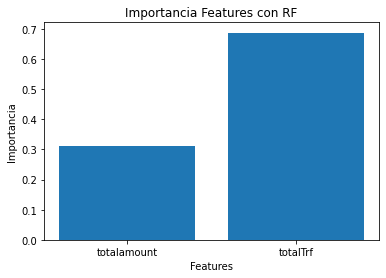

In [23]:
modelo.featureImportancia( X_train)

In [66]:
dfentrenami=entrenamiento[['Opportunity_ID','Territory','Stage']]
dfentrenami.head(5)

,Opportunity_ID,Territory,Stage
0,0,None,Closed Lost
1,1,None,Closed Won
2,2,NW America,Closed Won
3,3,NW America,Closed Lost
4,4,NW America,Closed Lost


In [67]:
df = dfentrenami.replace('Closed Won', '1')
df = df.replace('Closed Lost', '0')
df

,Opportunity_ID,Territory,Stage
0,0,None,0
1,1,None,1
2,2,NW America,1
3,3,NW America,0
4,4,NW America,0
...,...,...,...
16942,12801,Austria,1
16943,12801,Austria,1
16944,12801,Austria,1
16945,12802,NE America,0


In [68]:
df = df[df['Stage'].isin(['0','1'])]
df.Stage = df.Stage.astype(int)
df = df.groupby(['Territory','Opportunity_ID']).agg({'Stage':['sum','count']})
df = df.reset_index()
df1 = df
df1.columns = ['Territory','Opportunity_ID','Stage_sum','Stage_count']
df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
df2 = df1.groupby(['Territory']).agg(meanEncodingTerritory = ('Stage_sum','mean'))
df2 = df2.reset_index()
agruparOportunity=entrenamiento.groupby(['Opportunity_ID','Territory']).agg(cant=('Territory','count')).reset_index()
result=pd.merge(agruparOportunity,df2,on='Territory',how='inner')
result.head()
del result['cant']
 



/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
result

,Opportunity_ID,Territory,meanEncodingTerritory
0,0,None,0.535927
1,1,None,0.535927
2,8,None,0.535927
3,9,None,0.535927
4,10,None,0.535927
...,...,...,...
9834,10218,Oman,0.000000
9835,10419,Oman,0.000000
9836,7447,Burma,0.000000
9837,8677,Slovenia,1.000000


In [ ]:
del result['Opportunity_ID']

In [50]:
df = df[df['Stage'].isin(['0','1'])]
df

,Opportunity_ID,Territory,Stage
0,0,None,0
1,1,None,1
2,2,NW America,1
3,3,NW America,0
4,4,NW America,0
...,...,...,...
16942,12801,Austria,1
16943,12801,Austria,1
16944,12801,Austria,1
16945,12802,NE America,0


In [51]:
df.Stage = df.Stage.astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [52]:
df = df.groupby(['Territory','Opportunity_ID']).agg({'Stage':['sum','count']})
df = df.reset_index()
df

Territory Opportunity_ID Stage      
                                 sum count
0       Albania           6766     0     1
1       Albania           6848     0     1
2       Armenia           3323     0     2
3     Australia            271     1     1
4     Australia            272     1     1
...         ...            ...   ...   ...
9786    Vietnam           8728     0     1
9787    Vietnam           8867     2     2
9788    Vietnam           8972     3     3
9789    Vietnam           9026     1     1
9790    Vietnam           9869     1     1

[9791 rows x 4 columns]

In [53]:
df1 = df
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9791 entries, 0 to 9790
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   (Territory, )       9791 non-null   object
 1   (Opportunity_ID, )  9791 non-null   int64 
 2   (Stage, sum)        9791 non-null   int64 
 3   (Stage, count)      9791 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 306.1+ KB


In [54]:
df1.columns = ['Territory','Opportunity_ID','Stage_sum','Stage_count']
df1

,Territory,Opportunity_ID,Stage_sum,Stage_count
0,Albania,6766,0,1
1,Albania,6848,0,1
2,Armenia,3323,0,2
3,Australia,271,1,1
4,Australia,272,1,1
...,...,...,...,...
9786,Vietnam,8728,0,1
9787,Vietnam,8867,2,2
9788,Vietnam,8972,3,3
9789,Vietnam,9026,1,1


In [55]:
df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
df1

,Territory,Opportunity_ID,Stage_sum,Stage_count
0,Albania,6766,0,1
1,Albania,6848,0,1
2,Armenia,3323,0,2
3,Australia,271,1,1
4,Australia,272,1,1
...,...,...,...,...
9786,Vietnam,8728,0,1
9787,Vietnam,8867,1,2
9788,Vietnam,8972,1,3
9789,Vietnam,9026,1,1


In [56]:
df2 = df1.groupby(['Territory']).agg(meanEncodingTerritory = ('Stage_sum','mean'))
df2 = df2.reset_index()
df2

,Territory,meanEncodingTerritory
0,Albania,0.000000
1,Armenia,0.000000
2,Australia,0.663778
3,Austria,0.805556
4,Belarus,0.000000
...,...,...
70,UAE (Dubai),0.071429
71,UAE (Others),1.000000
72,Ukraine,0.000000
73,United Kingdom,0.390351


In [59]:
agruparOportunity=entrenamiento.groupby(['Opportunity_ID','Territory']).agg(cant=('Territory','count')).reset_index()
result=pd.merge(agruparOportunity,df2,on='Territory',how='inner')
result.head()
del result['cant']
del result['Territory']

In [60]:
result

,Opportunity_ID,meanEncodingTerritory
0,0,0.535927
1,1,0.535927
2,8,0.535927
3,9,0.535927
4,10,0.535927
...,...,...
9834,10218,0.000000
9835,10419,0.000000
9836,7447,0.000000
9837,8677,1.000000
